all the data was in an archive with the patients numbers as folders and inside the tumor and non tumor patches, we take all these out and merge them in 2 folders positive and negative

In [2]:
import os
import shutil

src = '../data/raw/'
dst = '../data/clean'

os.makedirs(f'{dst}/0', exist_ok=True)
os.makedirs(f'{dst}/1', exist_ok=True)

for patient_dir in os.listdir(src):
    patient_path = os.path.join(src, patient_dir)
    if not os.path.isdir(patient_path): continue

    zero_dir = os.path.join(patient_path,"0")
    one_dir = os.path.join(patient_path,"1")

    dir_name = os.path.splitext(patient_dir)[0]
    if dir_name.isdigit():
        for file in os.listdir(zero_dir):
            if file not in os.path.join(dst, "0"):
                filepath = os.path.join(zero_dir, file)
                shutil.move(filepath, os.path.join(dst, "0") )

        
        for file in os.listdir(one_dir):
            if file not in os.path.join(dst, "1"):
                filepath = os.path.join(one_dir, file)
                shutil.move(filepath, os.path.join(dst, "1") )

now we can start spliting the data and analizing it 

In [3]:
#the imports
import numpy as np
import matplotlib.pyplot as plt
import cv2

np.random.seed(42)

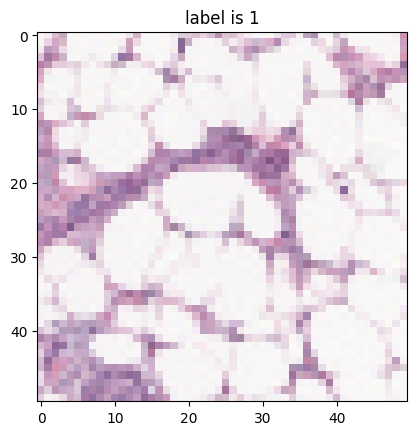

In [85]:
#let's get an image
def get_random_image():
    dataset = []
    for label in ["0","1"]:
        folder = os.path.join(dst,label)
        images_path = [os.path.join(folder,f) for f in os.listdir(folder)]
        dataset.extend((path, label) for path in images_path)

    idx = np.random.choice(len(dataset))
    label = dataset[idx][1]
    im = dataset[idx][0]
    im = cv2.imread(im)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    return im, label

def plot_random_image():
    im, label = get_random_image()
    plt.imshow(im)
    plt.title(f"label is {label}")

plot_random_image()


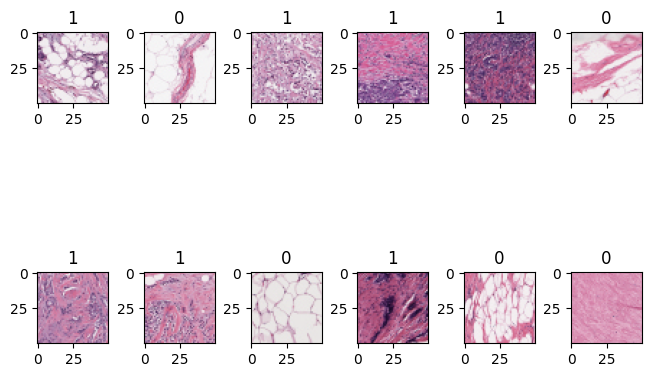

In [92]:

#let's see some many random images 
def plot_random_images(num_images=12, dataset = []):
    if len(dataset)==0:
        for label in ["0","1"]:
            folder = os.path.join(dst,label)
            images_path = [os.path.join(folder,f) for f in os.listdir(folder)]
            dataset.extend((path, label) for path in images_path)

    plt.figure(layout='constrained')

    sample = np.random.choice(len(dataset), size=num_images)
    for i,idx in enumerate(sample):
        image_path, label = dataset[idx]
        im = cv2.imread(image_path)
        im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

        plt.subplot(2,num_images//2, i+1)
        plt.imshow(im_rgb)
        plt.title(label)
    
    plt.show()

plot_random_images()

Now we're gonna separate all the images into training, validation and test sets, I've choosen a ratio of 70/15/15 for these, we're gonna have a list of everything and use NumPy's permutation method to shuffle them to avoid any possible data leak

In [ ]:
dataset = []
for label in ["0","1"]:
    folder = os.path.join(dst,label)
    images_path = [os.path.join(folder,f) for f in os.listdir(folder)]
    dataset.extend((path, label) for path in images_path)

pos_dataset=[]
neg_dataset=[]
for name, label in dataset:
    if label=="0":
        neg_dataset.append((name, label))
    else :
        pos_dataset.append((name, label))

train_ratio = 0.7
index_cut_pos = int(len(pos_dataset)*train_ratio)
index_cut_neg = int(len(neg_dataset)*train_ratio)

#print(len(pos_dataset))
#print(len(neg_dataset))


#we shuffle the dataset for more randomness
np.random.shuffle(pos_dataset)
np.random.shuffle(neg_dataset)

X_train_pos = pos_dataset[:index_cut_pos]
X_train_neg = neg_dataset[:index_cut_neg]
X_train = np.concatenate((X_train_pos, X_train_neg))

X_val_pos = pos_dataset[index_cut_pos:]
X_val_neg = neg_dataset[index_cut_neg:]


validation_pos_cut = len(X_val_pos)//2
validation_neg_cut = len(X_val_neg)//2

X_test = np.concatenate([X_val_pos[validation_pos_cut:], X_val_neg[validation_neg_cut:]])
X_val = np.concatenate([X_val_pos[:validation_pos_cut], X_val_neg[:validation_neg_cut]]) 

X_train size: 194266
Total string length: 365
['../data/clean\\1\\12868_idx5_x1751_y1801_class1.png' '1']


In [48]:
#paths
train_path = os.path.join(dst,"train")
val_path = os.path.join(dst, "validation")
test_path = os.path.join(dst, "test")

In [13]:
def copy_data(data, destination_path):
    print(f"Copying {data} set with {len(data)} images...")
    for i, (name, label) in enumerate(data):
        #for testing purposes
        #if i>=10000:
        #    break

        x_dir = os.path.join(destination_path,label)
        os.makedirs(x_dir, exist_ok=True)

        filename = os.path.basename(name)
        dst_path = os.path.join(x_dir,filename)
        shutil.copyfile(name,dst_path)

        if i%500==0:
            print(f'{i}/{len(data)} images have been copied')
    print('everything has been copied')

#copy_data(X_train,train_path)
#copy_data(X_val,val_path)
#copy_data(X_test, test_path)

Problem : this is a naive approach of randomly distributing patches without taking into account the whole slide, this may cause data leakage as the patches are not independant and the model may see in validation some patches from the same patient seen n training.

As the patches are correlated we will have some overly optimistic results, we will redo the data split, this time spliting by patients, then extracting all positive and negative patches, this may or may not cause some problematic distribution of + and - patches because not all patients have the same number of + patches, and we will adress this problem if we are faced to it.

But as of right now, we prefer avoiding data leakage.

In [24]:
patients = {}

for label in ["0", "1"]:
    current_dir = os.path.join(dst, label)

    for patch in os.listdir(current_dir):
        patch_path = os.path.join(current_dir, patch)
        patch_name = os.path.basename(patch)
        id = patch_name.split('_')[0]

        if id not in patients:
            patients[id] = []
        
        patients[id].append((patch_path, label))

#now we have a dictionary with the patients and their patches
patch_count = {k: len(v) for k, v in patients.items()}
print(f"The number of patiens is {len(patch_count)}")
print(f"the total number of patches is {sum(patch_count.values())}")
print(f"The average number of patches per patient is {sum(patch_count.values())/len(patch_count)}")


The number of patiens is 279
the total number of patches is 277524
The average number of patches per patient is 994.7096774193549


perfect, now we split by patients then copy the data

In [37]:
def split_data(data, train_ratio=0.7, seed=42):
    np.random.seed(seed)
    patient_ids = list(data.keys())
    np.random.shuffle(patient_ids)
    split_index = int(len(patient_ids)*train_ratio)

    training = set(patient_ids[:split_index])
    val = patient_ids[split_index:]
    test_split_index = len(val)//2
    testing = set(val[test_split_index:])
    val = set(val[:test_split_index])
    #we convert to sets for faster in checks


    X_train = []
    X_val = []
    X_test = []

    for k, v in data.items():
        if k in training:
            X_train.extend(patch for patch in v)
        elif k in val :
            X_val.extend(patch for patch in v)
        else:
            X_test.extend(patch for patch in v)
    
    return np.array(X_train), np.array(X_val), np.array(X_test)

In [ ]:
X_train, X_val, X_test = split_data(patients)

copy_data(X_train, train_path)
copy_data(X_val, val_path)
copy_data(X_test, test_path)

Copying [['../data/clean\\0\\10253_idx5_x1001_y1001_class0.png' '0']
 ['../data/clean\\0\\10253_idx5_x1001_y1051_class0.png' '0']
 ['../data/clean\\0\\10253_idx5_x1001_y1101_class0.png' '0']
 ...
 ['../data/clean\\1\\9382_idx5_x951_y1501_class1.png' '1']
 ['../data/clean\\1\\9382_idx5_x951_y1551_class1.png' '1']
 ['../data/clean\\1\\9382_idx5_x951_y1601_class1.png' '1']] set with 193299 images...
0/193299 images have been copied
500/193299 images have been copied
1000/193299 images have been copied
1500/193299 images have been copied
2000/193299 images have been copied
2500/193299 images have been copied
3000/193299 images have been copied
3500/193299 images have been copied
4000/193299 images have been copied
4500/193299 images have been copied
5000/193299 images have been copied
5500/193299 images have been copied
6000/193299 images have been copied
6500/193299 images have been copied
7000/193299 images have been copied
7500/193299 images have been copied
8000/193299 images have been

Let's verify we have some equal distribution of the images in our different folders

<class 'int'> <class 'int'> <class 'int'>
<class 'int'> <class 'int'> <class 'int'>
[0 1 2]


C:\Users\PC\AppData\Local\Temp\ipykernel_19816\126570909.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


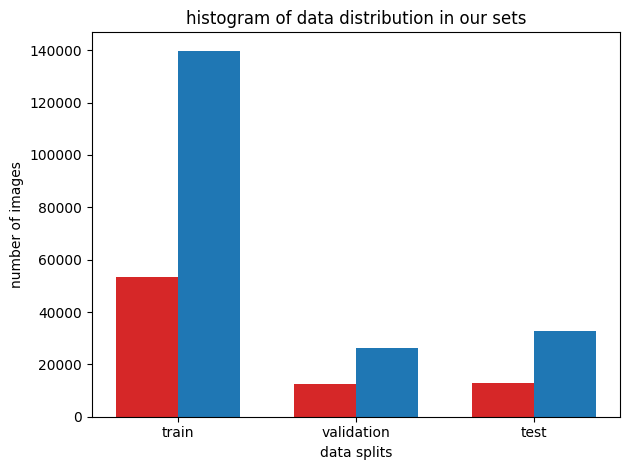

In [41]:
plt.figure(layout='constrained')


train_1 = len(os.listdir(os.path.join(dst,"train/1")))
train_0 = len(os.listdir(os.path.join(dst,"train/0")))
val_1 = len(os.listdir(os.path.join(dst,"validation/1")))
val_0 = len(os.listdir(os.path.join(dst,"validation/0")))
test_1 = len(os.listdir(os.path.join(dst,"test/1")))
test_0 = len(os.listdir(os.path.join(dst,"test/0")))

print(type(train_1), type(val_1), type(test_1))
print(type(train_0), type(val_0), type(test_0))

labels = ['train','validation','test']
x= np.arange(len(labels))
bar_width = 0.35
print(x)

positive_count = [train_1,val_1,test_1]
negative_count = [train_0,val_0,test_0]

plt.bar(x - bar_width/2, positive_count, width=bar_width, color='#d62728' )
plt.bar(x + bar_width/2, negative_count, width=bar_width, color='#1f77b4')

plt.xticks(x, labels)
plt.ylabel('number of images')
plt.xlabel('data splits')
plt.title('histogram of data distribution in our sets')
plt.tight_layout()

plt.show()

A pie chart to better see the proportions, if everything is good they should all look the same

Text(0.5, 1.0, 'testing set')

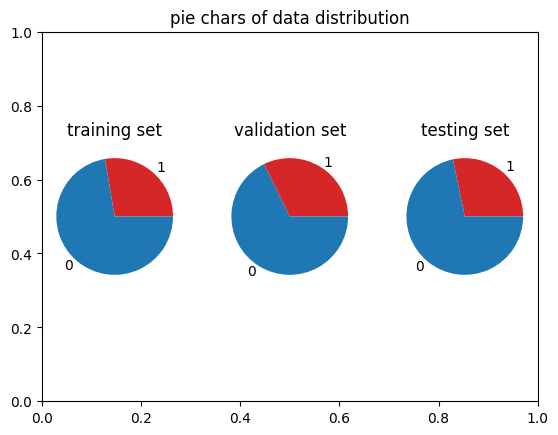

In [42]:
plt.figure()
plt.title('pie chars of data distribution')

plt.subplot(1,3,1)
plt.pie(x=[train_1, train_0], labels=['1','0'], colors=['#d62728', '#1f77b4'])
plt.title('training set')
plt.subplot(1,3,2)
plt.pie(x=[val_1, val_0], labels=['1','0'], colors=['#d62728', '#1f77b4'])
plt.title('validation set')
plt.subplot(1,3,3)
plt.pie(x=[test_1, test_0], labels=['1','0'], colors=['#d62728', '#1f77b4'])
plt.title('testing set')



We have about the same proportions in the different folders, so no problem on this side, we can then start the data preprocessing with tensorflow and keras 

In [114]:
#imports needed
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
import pydot
import graphviz

In [191]:
#for reproducability
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

X_train = image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=None,
    image_size=(50,50),
    shuffle=True,
    interpolation='nearest'
)

X_val = image_dataset_from_directory(
    val_path,
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=None,
    image_size=(50,50),
    shuffle=True,
    interpolation='nearest'
)

AUTOTUNE = tf.data.experimental.AUTOTUNE
def preprocess(image, label):
    image = tf.cast(image, tf.float32)/255 #we normalize the tensors to have them in the interval [0,1]
    return image, label


Found 193299 files belonging to 2 classes.
Found 38496 files belonging to 2 classes.


Let's now write the data augmentation pipeline, but only for positive patches, to balance the proportions a little bit because negatives are over represented

In [192]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical'),
    layers.RandomColorDegeneration(factor=(0.5,0.5)),
    layers.RandomBrightness(factor=0.2),
    layers.RandomContrast(factor=0.2),
    layers.RandomRotation(factor=(-0.2, 0.3)),
    layers.RandomInvert(factor=1.0, value_range=(0, 1))
])

def augmentation(image, label):
    return tf.cond(
        tf.equal(label,1),
        lambda: (data_augmentation(image), label),
        lambda: (image, label)
    )

We can finally preprocess with everything we have defined

In [193]:
print(tf.data.experimental.cardinality(X_train).numpy())
print(tf.data.experimental.cardinality(X_val).numpy())

X_train = (
    X_train
    .map(preprocess, num_parallel_calls=AUTOTUNE, deterministic=True)
    .map(augmentation, num_parallel_calls=AUTOTUNE, deterministic=True)
    .shuffle(buffer_size=1000)
    .batch(64)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
X_val = (
    X_val
    .map(preprocess, num_parallel_calls=AUTOTUNE, deterministic=True)
    .batch(64)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

print(tf.data.experimental.cardinality(X_train).numpy())
print(tf.data.experimental.cardinality(X_val).numpy())


193299
38496
3021
602


The data preprocessing is done, now we'll start the model building, first step is feature extraction, then the prediction model, we will be creating our own CNN model with keras from scratch

In [194]:
feature_extraction = [
        #input layer will be size 50x50x3
        layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', use_bias=False), #50x50x32 for base filters
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'), #25x25x32

        layers.Conv2D(filters=64, kernel_size=(3,3), use_bias=False), #25x25x64
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'), #12x12x64

        layers.Conv2D(filters=128, kernel_size=(3,3), use_bias=False), #12x12x128
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'), #6x6x128

        layers.Flatten() #4608
    ]

model_body = [
        layers.Dense(units=128, input_shape=[4608]),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        layers.Dense(units=128),
        layers.BatchNormalization(),  
        layers.Activation('relu'),
        layers.Dropout(0.3),
        

        layers.Dense(units=1, activation='sigmoid')
    ]


C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Now we assemble the model, compile and we can generate a graphical representation.

As a metric to evaluate, Recall is the most important, because we are detecting cancer cases, what we want to avoid the most are false negatives, as the consequences can be very bad while a false positive may only require some more testing.

In [195]:
model = tf.keras.Sequential([
    *feature_extraction,
    *model_body
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy', 
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.AUC(name='auc')
        ]
)

#we add a callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor= "val_loss",
    min_delta= 0.01,
    patience= 5,
    mode='min',
    restore_best_weights=True,
    start_from_epoch=10
)

In [196]:
model.build()
tf.keras.utils.plot_model(
    model,
    to_file='/model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=200,
    show_layer_activation=True,
    show_trainable=True
)


You must install pydot (`pip install pydot`) for `plot_model` to work.


before we fit the model, we will write some callback for saving our model every 5 epochs so we can let the training go and comeback later

In [197]:
os.makedirs("../model/model1/checkpoints", exist_ok=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "../model/model1/checkpoints/{epoch:02d}-{val_loss:.2f}.keras",
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    save_freq='epoch'
)

We add a last callback to plot dynamically our progress in training 

In [201]:
class plotLearning(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs=None):
        plt.plot(self.model.history.history['loss'], label='train loss')
        plt.plot(self.model.history.history['val_loss'], label='val loss')
        plt.legend()
        plt.show()
plot_learning = plotLearning()

We can now fit our custom ConvNet !

In [ ]:
history = model.fit(
    X_train,
    epochs=60,
    verbose=1,
    callbacks=[early_stopping, checkpoint, plot_learning],
    validation_split=0,
    validation_data=X_val,
    validation_steps=None,
    validation_freq=1
)

Epoch 1/60
  71/3021 ━━━━━━━━━━━━━━━━━━━━ 10:08 206ms/step - auc: 0.9912 - binary_accuracy: 0.9563 - loss: 0.1092 - precision: 0.9048 - recall: 0.9364